
Source codes for Python Machine Learning By Example 4th Edition (Packt Publishing)

Chapter 2 Building A Movie Recommendation Engine with Naive Bayes

Author: Yuxi (Hayden) Liu (yuxi.liu.ece@gmail.com)


# Building a movie recommender with Naïve Bayes

In [1]:
import numpy as np
import pandas as pd
from pyhere import here

In [2]:
import requests
import os

def download_file(url, download_dir, filename):
    """
    Downloads a file from a given URL and saves it to a specified directory.

    Parameters:
    url (str): The URL of the file to be downloaded.
    download_dir (str): The directory where the file will be saved.
    filename (str): The name of the file to be saved.

    Returns:
    None

    Raises:
    requests.exceptions.RequestException: If there is an error during the download process.

    Example:
    >>> download_file('https://example.com/file.zip', here('data'), 'file.zip')
    File downloaded successfully and saved as here('data/file.zip')
    """    
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Check if the request was successful

        # Ensure the data directory exists
        # os.makedirs(os.path.dirname(destination), exist_ok=True)
        os.makedirs(download_dir, exist_ok=True)
        os.chdir(download_dir)

        with open(filename, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        os.chdir(here("."))
        print(f"File downloaded successfully and saved as {download_dir}")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")


In [3]:
import zipfile

def unzip_file(zip_file_path, extract_dir):
    """
    Unzips a file to a specified directory.

    Parameters:
    zip_file_path (str): The path to the zip file to be unzipped.
    extract_dir (str): The directory where the contents will be extracted.

    Returns:
    None

    Raises:
    zipfile.BadZipFile: If the zip file is corrupted or not a valid zip file.

    Example:
    >>> unzip_file(here('data/ml-1m.zip'), here('data'))
    File unzipped successfully and extracted to here('data')
    """
    try:
       # Ensure the extract directory exists
        os.makedirs(extract_dir, exist_ok=True)

        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"File unzipped successfully and extracted to {extract_dir}")

    except zipfile.BadZipFile as e:
        print(f"Error unzipping file: {e}")

# Path to the downloaded zip file
# zip_file_path = os.path.join(download_dir, filename)
# extract_dir = download_dir

# Unzip the file
# unzip_file(zip_file_path, extract_dir)

In [4]:
# URL of the file to download
url = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
filename = os.path.basename(url)
download_dir = here("data")

# check if file exists
path_to_check = here('data', filename)
if os.path.exists(path_to_check):
    print(f"The file '{filename}' exists in the directory '{download_dir}'.")
else:
    # Download the file
    # check if file exists
    print(f"The file '{filename}' does not exist in the directory '{download_dir}'.")
    download_file(url, download_dir, filename)
    unzip_file(here(download_dir, filename), here(download_dir, "ch02"))


The file 'ml-1m.zip' exists in the directory '/Users/vincent/Programming/python/Python-Machine-Learning-by-Example-Fourth-Edition/data'.


In [5]:
data_path = here('data', 'ch02', 'ml-1m/ratings.dat')
df = pd.read_csv(data_path, header=None, sep='::', engine='python')
df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
print(df)

         user_id  movie_id  rating  timestamp
0              1      1193       5  978300760
1              1       661       3  978302109
2              1       914       3  978301968
3              1      3408       4  978300275
4              1      2355       5  978824291
...          ...       ...     ...        ...
1000204     6040      1091       1  956716541
1000205     6040      1094       5  956704887
1000206     6040       562       5  956704746
1000207     6040      1096       4  956715648
1000208     6040      1097       4  956715569

[1000209 rows x 4 columns]


In [6]:
n_users = df['user_id'].nunique()
n_movies = df['movie_id'].nunique()
print(f"Number of users: {n_users}")
print(f"Number of movies: {n_movies}")

Number of users: 6040
Number of movies: 3706


In [48]:
# Using functional programming to find the number of unique instances in a column
unique_counts = {col: df[col].nunique() for col in ['user_id', 'movie_id', 'rating']}
print(unique_counts)

{'user_id': 6040, 'movie_id': 3706, 'rating': 5}


In [17]:
df.groupby('rating')['rating'].count()

rating
1     56174
2    107557
3    261197
4    348971
5    226310
Name: rating, dtype: int64

In [18]:
# How many movie ratings has each user given?
df.groupby('user_id')['rating'].count().sort_values(ascending=False).head(10)

user_id
4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
889     1518
3618    1344
2063    1323
1150    1302
1015    1286
Name: rating, dtype: int64

In [7]:
df.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


The top 10 users with the most movie ratings.

In [8]:
def load_user_rating_data(df, n_users, n_movies):
    data = np.zeros([n_users, n_movies], dtype=np.intc)
    movie_id_mapping = {}
    for user_id, movie_id, rating in zip(df['user_id'], df['movie_id'], df['rating']):
        user_id = int(user_id) - 1
        if movie_id not in movie_id_mapping:
            movie_id_mapping[movie_id] = len(movie_id_mapping)
        data[user_id, movie_id_mapping[movie_id]] = rating
    return data, movie_id_mapping

data, movie_id_mapping = load_user_rating_data(df, n_users, n_movies)

In [9]:
data[0:2, :]

array([[5, 3, 3, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0]], shape=(2, 3706), dtype=int32)

In [11]:
data[0, :]

array([5, 3, 3, ..., 0, 0, 0], shape=(3706,), dtype=int32)

**Equivalent R function for above**

```R
load_user_rating_data <- function(df, n_users, n_movies) {
  # Initialize the data matrix with zeros
  data <- matrix(0, nrow = n_users, ncol = n_movies)

  # Create a movie ID mapping
  movie_id_mapping <- c()

  # Iterate over the DataFrame rows
  for (i in 1:nrow(df)) {
    user_id <- df[i, "user_id"] - 1  # Adjust user_id to be zero-based
    movie_id <- df[i, "movie_id"]
    rating <- df[i, "rating"]

    # Map movie_id to a new index if not already mapped
    if (!(movie_id %in% names(movie_id_mapping))) {
      movie_id_mapping[movie_id] <- length(movie_id_mapping)
    }

    # Populate the data matrix
    data[user_id + 1, movie_id_mapping[movie_id] + 1] <- rating
  }

  # Return the data matrix and movie ID mapping
  list(data = data, movie_id_mapping = movie_id_mapping)
}
```
Alternatively, it looks like you can use `pivot_wider` function. e.g. pivot_wider(df, names_from = movie_id, values_from = rating, values_fill = 0).
The `values_fill` argument is used to fill in missing values with 0.

In [55]:
values, counts = np.unique(data, return_counts=True) 
for value, count in zip(values, counts): 
    print(f'Number of rating {value}: {count}') 

Number of rating 0: 21384031
Number of rating 1: 56174
Number of rating 2: 107557
Number of rating 3: 261197
Number of rating 4: 348971
Number of rating 5: 226310


The '0' rating cames from np.zeroes(n_users, n_movies).

In [21]:
data[[1]]

array([[5, 0, 0, ..., 0, 0, 0]], shape=(1, 3706), dtype=int32)

In [22]:
print(df['movie_id'].value_counts())

movie_id
2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
3458       1
2226       1
1815       1
398        1
2909       1
Name: count, Length: 3706, dtype: int64


In [12]:
target_movie_id = 2858
X_raw = np.delete(data, movie_id_mapping[target_movie_id], axis=1)
Y_raw = data[:, movie_id_mapping[target_movie_id]]

# using rows where the target movie as a rating > 0.
X = X_raw[Y_raw > 0]
Y = Y_raw[Y_raw > 0]

print('Shape of X:', X.shape)
print('Shape of Y:', Y.shape)


Shape of X: (3428, 3705)
Shape of Y: (3428,)


In [13]:
# What does X_raw and X looks like?
print(X_raw.shape)
print(X.shape)

(6040, 3705)
(3428, 3705)


In [14]:
# What does Y_raw and Y look like?
print(Y_raw.shape)
print(Y.shape)

(6040,)
(3428,)


In [68]:
# check out what Y_raw and X_raw looks like
print('Shape of X_raw:', X_raw.shape)
print('Shape of Y_raw:', Y_raw.shape)

Shape of X_raw: (6040, 3705)
Shape of Y_raw: (6040,)


In [24]:
X

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 3, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0]], shape=(3428, 3705), dtype=int32)

In [27]:
# For the first user, what are the tallys for their ratings.
# What is the most common rating given by the first user?
unique_values_1, counts_of_values_1 = np.unique(X[0], return_counts=True)
print("Original Unique Values:", unique_values_1)
print("Original Counts:", counts_of_values_1)

Original Unique Values: [0 1 2 3 4 5]
Original Counts: [3577    2   11   43   38   34]


In [28]:
# What would be the most common rating given by all users?
unique_values, counts_of_values = np.unique(X, return_counts=True)
print("Original Unique Values:", unique_values)
print("Original Counts:", counts_of_values)

Original Unique Values: [0 1 2 3 4 5]
Original Counts: [11986488    39995    79832   189550   250231   154644]


In [30]:
# Normalize the counts
# counts_of_values = counts_of_values[1:]
normalized_counts = counts_of_values[1:] / np.sum(counts_of_values[1:])
print("Normalized Counts:", normalized_counts)

Normalized Counts: [0.05599564 0.11177008 0.26538253 0.35033994 0.21651182]


The most common ratings given is 4, followed by 3, 5, 2 and finally 1.

In [25]:
Y_raw

array([0, 4, 4, ..., 0, 0, 4], shape=(6040,), dtype=int32)

In [15]:
recommend = 3
Y[Y <= recommend] = 0
Y[Y > recommend] = 1

n_pos = (Y == 1).sum()
n_neg = (Y == 0).sum()
print(f'{n_pos} positive samples and {n_neg} negative samples.')


2853 positive samples and 575 negative samples.


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(len(Y_train), len(Y_test))

2742 686


In [17]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=1.0, fit_prior=True)
clf.fit(X_train, Y_train)


MultinomialNB()

`clf` is the trained Multinomial Naive Bayes classifer that can be used to make predictions on new data.

In [29]:
prediction_prob = clf.predict_proba(X_test)
print(prediction_prob[0:10])

prediction = clf.predict(X_test)
print(prediction[:10])

accuracy = clf.score(X_test, Y_test)
print(f'The accuracy is: {accuracy*100:.1f}%')


[[7.50487439e-23 1.00000000e+00]
 [1.01806208e-01 8.98193792e-01]
 [3.57740570e-10 1.00000000e+00]
 [1.00000000e+00 2.94095407e-16]
 [1.00000000e+00 2.49760836e-25]
 [7.62630220e-01 2.37369780e-01]
 [3.47479627e-05 9.99965252e-01]
 [2.66075292e-11 1.00000000e+00]
 [5.88493563e-10 9.99999999e-01]
 [9.71326867e-09 9.99999990e-01]]
[1 1 1 0 0 0 1 1 1 1]
The accuracy is: 71.6%


For `prediction_prob` the first value is prediction for class 0 and second value is prediction for class 1.

# Evaluating classification performance

In [30]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, prediction, labels=[0, 1]))

[[ 60  47]
 [148 431]]


|  <i></i>             | Predicted Negative | Predicted Positive |
|---------------|-------------------|--------------------|
| Actual Negative | True Negative (TN) 60 | False Positive (FP) 47 |
| Actual Positive | False Negative (FN) 148 | True Positive (TP) 431 |


In [31]:
print(confusion_matrix(Y_test, prediction, labels=[0, 1]))

[[ 60  47]
 [148 431]]


In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(Y_test, prediction, pos_label=1)

0.9016736401673641

Precision is the fraction of true positives out of all positive predictions. It is also known as positive predictive value.

In [33]:
recall_score(Y_test, prediction, pos_label=1)

0.7443868739205527

Recall is is the fraction of true positives out of all actual positives. It is also known as sensitivity or true positive rate.

In [34]:
f1_score(Y_test, prediction, pos_label=1)

0.815515610217597

In [35]:
f1_score(Y_test, prediction, pos_label=0) 

0.38095238095238093

The f1 score comprehensively includes both the precision and the recall and equates to their harmonic mean:
$$
f_1 = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
$$

In [36]:
from sklearn.metrics import classification_report
report = classification_report(Y_test, prediction)
print(report)

              precision    recall  f1-score   support

           0       0.29      0.56      0.38       107
           1       0.90      0.74      0.82       579

    accuracy                           0.72       686
   macro avg       0.60      0.65      0.60       686
weighted avg       0.81      0.72      0.75       686



In [37]:
pos_prob = prediction_prob[:, 1]

thresholds = np.arange(0.0, 1.1, 0.05)
true_pos, false_pos = [0]*len(thresholds), [0]*len(thresholds)
for pred, y in zip(pos_prob, Y_test):
    for i, threshold in enumerate(thresholds):
        if pred >= threshold:
            if y == 1:
                true_pos[i] += 1
            else:
                false_pos[i] += 1
        else:
            break

n_pos_test = (Y_test == 1).sum()
n_neg_test = (Y_test == 0).sum()
true_pos_rate = [tp / n_pos_test for tp in true_pos]
false_pos_rate = [fp / n_neg_test for fp in false_pos]


<positron-console-cell-38>:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


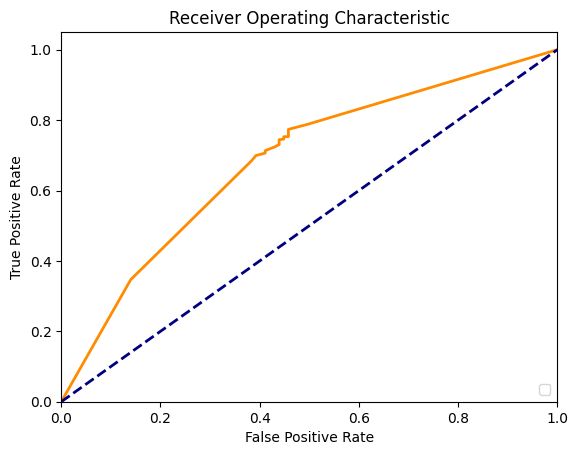

In [38]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color='darkorange', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [39]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(Y_test, pos_prob))

0.6857375752586637


# Tuning models with cross-validation

In [43]:
from sklearn.model_selection import StratifiedKFold
k = 5
k_fold = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

smoothing_factor_option = [1, 2, 3, 4, 5, 6]
fit_prior_option = [True, False]
auc_record = {}

for train_indices, test_indices in k_fold.split(X, Y):
    X_train_k, X_test_k = X[train_indices], X[test_indices]
    Y_train_k, Y_test_k = Y[train_indices], Y[test_indices]
    for alpha in smoothing_factor_option:
        if alpha not in auc_record:
            auc_record[alpha] = {}
        for fit_prior in fit_prior_option:
            clf = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
            clf.fit(X_train_k, Y_train_k)
            prediction_prob = clf.predict_proba(X_test_k)
            pos_prob = prediction_prob[:, 1]
            auc = roc_auc_score(Y_test_k, pos_prob)
            auc_record[alpha][fit_prior] = auc + auc_record[alpha].get(fit_prior, 0.0)


print('smoothing  fit prior  auc')
for smoothing, smoothing_record in auc_record.items():
    for fit_prior, auc in smoothing_record.items():
        print(f'    {smoothing}        {fit_prior}    {auc/k:.5f}')


smoothing  fit prior  auc
    1        True    0.65280
    1        False    0.65274
    2        True    0.65108
    2        False    0.65274
    3        True    0.65313
    3        False    0.65322
    4        True    0.65397
    4        False    0.65430
    5        True    0.65455
    5        False    0.65448
    6        True    0.65478
    6        False    0.65404


In [44]:
clf = MultinomialNB(alpha=2.0, fit_prior=False)
clf.fit(X_train, Y_train)

pos_prob = clf.predict_proba(X_test)[:, 1]
print('AUC with the best model:', roc_auc_score(Y_test, pos_prob))

AUC with the best model: 0.6862056720417091


---

Readers may ignore the next cell.

In [23]:
!jupyter nbconvert --to python ch2_part2.ipynb --TemplateExporter.exclude_input_prompt=True

[NbConvertApp] Converting notebook ch2_part2.ipynb to python
[NbConvertApp] Writing 5571 bytes to ch2_part2.py
